<a href="https://colab.research.google.com/github/luczeng/CapstoneAISC/blob/master/BaselineModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note:
# In this notebook, we are gonna explore the RSNA dataset and apply a simple SIFT + SVC classifier on it

%pip install wget
%pip install kaggle
x = !kaggle --version
if x[0] != 'Kaggle API 1.5.6':
  !pip install --upgrade --force-reinstall --no-deps kaggle  # need updated kaggle
!pip install matplotlib
!pip install pydicom
!pip install -U scikit-learn
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.1)


In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
import cv2
from sklearn.svm import SVC


In [ ]:
# Download kaggle dataset. 
# Please create a folder named 'Kaggle in your google drive'. Then upload your kaggle.json API token within this folder.
# For the RSNA pneumonia detection challenge, you need to accept the terms and conditions on the corresponding kaggle page first.
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

if not Path('stage_2_train_images').exists():
  !kaggle competitions download -c rsna-pneumonia-detection-challenge
  !unzip \*.zip  && rm *.zip
  !ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [ ]:
# Splits the train set into a test and train set
import csv
import os
import shutil

def split_test_train(train_folder_path, train_labels, new_train_label_path, test_folder, test_label_path, n_test_images):
  '''
    Splits the train set into test images

    :param train_folder_path
    :param train_labels
    :param test_folder
    :param test_label_path
    :param n_test_images
  '''

  os.makedirs(test_folder, exist_ok=True)

  with open(train_labels, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

  # Prepare test labels and move images
  labels = []
  for img in data[1:n_test_images]:
    img_path = train_folder_path + '/' + img[0] + '.dcm'
    new_img_path = test_folder + '/' + img[0] + '.dcm'
    if Path(img_path).exists():  #there can be several annotations per image
      shutil.move(img_path, new_img_path)
      labels.append(img)
  
  # Prepare train labels
  train_labels = []
  for img in data[n_test_images+1:]:
    train_labels.append(img)

  # Write test labels to disk
  labels.insert(0, data[0])
  with open(test_label_path,'w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerows(labels)

  # Write train labels to disk
  train_labels.insert(0, data[0])
  with open(new_train_label_path,'w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerows(train_labels)

  return img, labels

split_test_train('stage_2_train_images', 'stage_2_train_labels.csv', 'cleaned_train_labels.csv', 'test_images', 'test_labels.csv', 100)
!ls

KeyboardInterrupt: ignored

 cleaned_train_labels.csv	        stage_2_test_images
'GCP Credits Request Link - RSNA.txt'   stage_2_train_images
 kaggle.json			        stage_2_train_labels.csv
 stage_2_detailed_class_info.csv        test_images
 stage_2_sample_submission.csv	        test_labels.csv


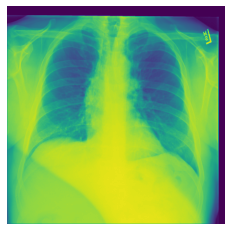


Number of training images : 26606
Number of training images : 0
Image shape: (1024, 1024)


In [ ]:
# Display one image 
!ls
train_files = Path('stage_2_train_images').iterdir()
test_files = Path('stage_2_test_images').iterdir()
dataset = pydicom.dcmread(str(next(train_files)))
plt.imshow(dataset.pixel_array)
plt.axis('off')
plt.show()

# Print dataset info
print(f"\nNumber of training images : {len(list(train_files))}")
print(f"Number of training images : {len(list(test_files))}")
print(f"Image shape: {dataset.pixel_array.shape}")

In [ ]:
# Create Hog and Sift transformers class 
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
import numpy as np
N_desc = 2
class SiftTransformer(BaseEstimator):
  ''' 
    Applies SIFT on array of 2d arrays
  '''

  def _local_sift(self, X, N = 64):
    '''
      Returns N concatenated sift descriptors
    '''
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = N)
    (kps1, descs1) = sift.detectAndCompute(dataset.pixel_array, None)
    
    features = np.zeros((N,130))
    for idx, (kp, desc) in enumerate(zip(kps1, descs1)):
      features[idx,0] = kp.pt[0]
      features[idx,1] = kp.pt[1]
      features[idx,2:] = desc
    return features

  def transform(self,imgs_names, N_desc):
    '''
      Applies SIFT on list of imgs
    '''

    imgs = np.zeros((N_desc, 130, len(imgs_names)))
    for i in range(len(imgs_names)):
      print(f"{i}/{len(imgs_names)}")
      dataset = pydicom.dcmread(str(imgs_names[i]))
      imgs[:,:,i] = self._local_sift(dataset.pixel_array, N_desc)

    return self._local_sift(imgs)

#train_files = Path('stage_2_train_images').iterdir()
#tf = SiftTransformer()
#x = tf.transform(list(train_files), N_desc)
#print(x.shape)

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(16, 16),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(X[:,:,idx]) for idx in range(X.shape[2])])
        except:
            return np.array([local_hog(img) for img in X])




In [ ]:
# Define loader
import csv
from pathlib import Path
import numpy as np


def dataloader(folder_path, period, label_path):
  '''
    Returns a list of images parsed at the given period

    :param folder_path path to folder containing images
    :param period integer indicating at which period images need to be sampled
    :param label_path path to csv file containing labels
  '''

  with open(label_path, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

  # First sample
  img_path = folder_path + '/' + data[1][0] + '.dcm'
  dataset = pydicom.dcmread(img_path)
  imgs = dataset.pixel_array
  labels = [int(data[1][5])]
  for file in data[2::period]:
    img_path = folder_path+ '/' + file[0] + '.dcm'
    dataset = pydicom.dcmread(img_path)
    imgs = np.dstack((imgs,dataset.pixel_array))
    labels.append(int(file[5]))

  return imgs, labels



In [ ]:
# Prepare training data
train_imgs, train_labels = dataloader('stage_2_train_images', 25, 'cleaned_train_labels.csv')
print(f'Number of training samples : {train_imgs.shape[2]}')

Number of training samples : 1207


In [ ]:
# Create training data
hogify = HogTransformer(
    pixels_per_cell=(16, 16),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)

train_files = Path('stage_2_train_images').iterdir()
hog_features = hogify.transform(train_imgs)

print(hog_features.shape)

(1207, 142884)


In [ ]:
# Run and train SVM
from sklearn.linear_model import SGDClassifier
from sklearn import svm

clf = svm.SVC(kernel='rbf', gamma=0.1, C=1, verbose = 1)
clf.fit(hog_features, train_labels)
print(clf)


#sgd_clf = SGDClassifier(random_state=42, max_iter=10000000, tol=1e-4)
#sgd_clf.fit(hog_features, train_labels)


[LibSVM]SVC(C=1, gamma=0.1, verbose=1)


In [ ]:
# Predict on train dataset
predictions = clf.predict(hog_features)
print(list(predictions))
print(train_labels)
acc = [abs(pred - lbl) for pred, lbl in zip(list(predictions), train_labels)]
print('Training error: ',sum(acc))

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [ ]:
# Create testing data
test_imgs, test_labels = dataloader('test_images', 1, 'test_labels.csv')
test_hog_features = hogify.transform(test_imgs)
print(test_imgs.shape, test_hog_features.shape)



(1024, 1024, 77) (77, 142884)


In [ ]:
# Predict
predictions = clf.predict(test_hog_features)
print(predictions)
print(test_labels)
acc = [abs(pred - lbl) for pred, lbl in zip(list(predictions), test_labels)]
print('Test error: ',sum(acc))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
Test error:  27


In [ ]:
# Save classifier to disk
import joblib
joblib.dump(clf, 'svm.pkl')


['svm.pkl']